In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import re
import textdistance
import numpy as np
%matplotlib inline

DATA_DIR = '../../data/'

In [2]:
# !pip install textdistance

In [3]:
def validate_route(r):
    return len(r) == 1 or r == "SI"

In [4]:
routes = pd.read_csv(DATA_DIR + 'raw/google_transit/routes.txt')
routes = routes[(routes.route_type == 1)]
routes = routes[routes.route_id.apply(validate_route)]
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1,MTA NYCT,1,Broadway - 7 Avenue Local,Trains operate between 242 St in the Bronx and...,1,http://web.mta.info/nyct/service/pdf/t1cur.pdf,EE352E,NaN
1,2,MTA NYCT,2,7 Avenue Express,"Trains operate between Wakefield-241 St, Bronx...",1,http://web.mta.info/nyct/service/pdf/t2cur.pdf,EE352E,
2,3,MTA NYCT,3,7 Avenue Express,"Trains operate between 148 St, 7 Av, Manhattan...",1,http://web.mta.info/nyct/service/pdf/t3cur.pdf,EE352E,NaN
3,4,MTA NYCT,4,Lexington Avenue Express,Trains operate daily between Woodlawn/Jerome A...,1,http://web.mta.info/nyct/service/pdf/t4cur.pdf,00933C,NaN
4,5,MTA NYCT,5,Lexington Avenue Express,"Weekdays daytime, most trains operate between ...",1,http://web.mta.info/nyct/service/pdf/t5cur.pdf,00933C,NaN


In [5]:
stops = pd.read_csv(DATA_DIR + 'raw/google_transit/stops.txt')
platforms = stops[stops.location_type == 0][['stop_id', 'stop_name']]
platforms.head()

,stop_id,stop_name
1,101N,Van Cortlandt Park - 242 St
2,101S,Van Cortlandt Park - 242 St
4,103N,238 St
5,103S,238 St
7,104N,231 St


In [6]:
stop_times = pd.read_csv(DATA_DIR + 'raw/google_transit/stop_times.txt')
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,AFA19GEN-1037-Sunday-00_000600_1..S03R,00:06:00,00:06:00,101S,1,NaN,0,0,NaN
1,AFA19GEN-1037-Sunday-00_000600_1..S03R,00:07:30,00:07:30,103S,2,NaN,0,0,NaN
2,AFA19GEN-1037-Sunday-00_000600_1..S03R,00:09:00,00:09:00,104S,3,NaN,0,0,NaN
3,AFA19GEN-1037-Sunday-00_000600_1..S03R,00:10:30,00:10:30,106S,4,NaN,0,0,NaN
4,AFA19GEN-1037-Sunday-00_000600_1..S03R,00:12:00,00:12:00,107S,5,NaN,0,0,NaN


In [7]:
weekday = stop_times[stop_times.trip_id.str.contains('Weekday')] # filter to weekday
weekday.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
22192,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:06:30,00:06:30,101S,1,NaN,0,0,NaN
22193,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:08:00,00:08:00,103S,2,NaN,0,0,NaN
22194,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:09:30,00:09:30,104S,3,NaN,0,0,NaN
22195,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:11:00,00:11:00,106S,4,NaN,0,0,NaN
22196,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:12:30,00:12:30,107S,5,NaN,0,0,NaN


In [8]:
def get_pairs(l):
    return [f"{l[i]},{l[i+1]}" for i in range(len(l) - 1)]

In [9]:
trip_conns = weekday.sort_values(['stop_sequence']).groupby(['trip_id'], sort=False)['stop_id'].apply(list).reset_index(name='stations')
trip_conns['stations'] = trip_conns['stations'].apply(get_pairs) # get pairs of stops
trip_conns = trip_conns.set_index('trip_id').stations.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'stations'}) # explode result
trip_conns.head()

,trip_id,stations
0,AFA19GEN-1087-Weekday-00_000650_1..S03R,"101S,103S"
1,AFA19GEN-1087-Weekday-00_000650_1..S03R,"103S,104S"
2,AFA19GEN-1087-Weekday-00_000650_1..S03R,"104S,106S"
3,AFA19GEN-1087-Weekday-00_000650_1..S03R,"106S,107S"
4,AFA19GEN-1087-Weekday-00_000650_1..S03R,"107S,108S"


In [10]:
line_conns = trip_conns
line_conns['line'] = line_conns.trip_id.str.extract(r'.*_(\w*)\..*') # extract line from trip id
line_conns = line_conns[line_conns.line.apply(validate_route)] # remove special case lines
line_conns.head()

,trip_id,stations,line
0,AFA19GEN-1087-Weekday-00_000650_1..S03R,"101S,103S",1
1,AFA19GEN-1087-Weekday-00_000650_1..S03R,"103S,104S",1
2,AFA19GEN-1087-Weekday-00_000650_1..S03R,"104S,106S",1
3,AFA19GEN-1087-Weekday-00_000650_1..S03R,"106S,107S",1
4,AFA19GEN-1087-Weekday-00_000650_1..S03R,"107S,108S",1


In [11]:
station_conns = line_conns
station_conns = station_conns.groupby(['line', 'stations']).size().to_frame('num_trips').reset_index() # get trips between stations by line
station_conns[['from','to']] = station_conns.stations.str.split(",", expand=True)
station_conns.head(3)

,line,stations,num_trips,from,to
0,1,"101S,103S",209,101S,103S
1,1,"103N,101N",222,103N,101N
2,1,"103S,104S",225,103S,104S


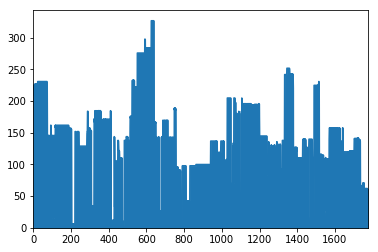

In [12]:
station_conns.num_trips.plot(kind='area')

In [13]:
t = station_conns
t = t[t.num_trips < 20]
t = pd.merge(t, platforms.rename(columns={'stop_name':'from_name', 'stop_id':'from'}))
t = pd.merge(t, platforms.rename(columns={'stop_name':'to_name', 'stop_id':'to'}))
t.head()
#line_conns[(line_conns.stations=="120S,121S")&(line_conns.line=="2")]
#stop_times[stop_times.trip_id=="AFA19GEN-2097-Weekday-00_024900_2..S08R"]

,line,stations,num_trips,from,to,from_name,to_name
0,2,"120S,121S",16,120S,121S,96 St,86 St
1,2,"121N,120N",16,121N,120N,86 St,96 St
2,2,"121S,122S",16,121S,122S,86 St,79 St
3,2,"122N,121N",16,122N,121N,79 St,86 St
4,2,"122S,123S",16,122S,123S,79 St,72 St


In [18]:
station_conns[['from', 'to', 'line']].reset_index(drop=True).to_csv(DATA_DIR + 'processed/station_to_station.csv')